<table style="width:100%; border-collapse: collapse;">
  <tr>
    <td style="width:20%; vertical-align:middle;">
      <img src="LogoUVG.png" width="400"/>
    </td>
    <td style="text-align:left; vertical-align:middle;">
      <h2 style="margin-bottom: 0;">Universidad del Valle de Guatemala - UVG</h2>
      <h3 style="margin-top: 0;">Facultad de Ingeniería - Computación</h3>
      <p style="font-size: 16px; margin-bottom: 0; margin-top: -20px">
        <strong>Curso:</strong> Visión por Computadora 
        <strong>Sección:</strong> 10
      </p>
      <p style="font-size: 16px; margin: 0;"><strong>Proyecto 4:</strong> Redes Neuronales Convolucionales</p>
      <br>
      <p style="font-size: 15px; margin: 0;"><strong>Autores:</strong></p>
      <ul style="margin-top: 5px; padding-left: 20px; font-size: 15px;">
        <li>Diego Alexander Hernández Silvestre - <strong>21270</strong></li>
        <li>Linda Inés Jiménez Vides - <strong>21169</strong></li>
        <li>José Andrés Auyón Cobar - <strong>201579</strong></li>
      </ul>
    </td>
  </tr>
</table>

# 2. Imports básicos y configuración de paths



In [2]:
import os
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torchvision.models as models

import cv2
import matplotlib.pyplot as plt

# Detectar si hay GPU disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

# Use absolute paths directly
DATA_DIR = r"d:/UVG/Vision/Proyecto4/data"
CSV_PATH = r"d:/UVG/Vision/Proyecto4/data/data.csv"

# Print paths for verification
print(f"Using DATA_DIR: {DATA_DIR}")
print(f"Using CSV_PATH: {CSV_PATH}")

# Check if paths exist
if not os.path.exists(DATA_DIR):
    raise FileNotFoundError(f"Dataset directory not found at: {DATA_DIR}")
if not os.path.exists(CSV_PATH):
    raise FileNotFoundError(f"CSV file not found at: {CSV_PATH}")

# If paths exist, proceed with reading
try:
    df = pd.read_csv(CSV_PATH, sep=";")
    print("Successfully read CSV file")
    print("\nFirst 5 rows:")
    print(df.head())
except Exception as e:
    print(f"Error reading CSV: {str(e)}")

Usando dispositivo: cpu
Using DATA_DIR: d:/UVG/Vision/Proyecto4/data
Using CSV_PATH: d:/UVG/Vision/Proyecto4/data/data.csv
Successfully read CSV file

First 5 rows:
  filename    weight  age     sex
0  1G1.jpg  2.314851   24  Hembra
1  2G1.jpg  2.094389   24  Hembra
2  3G1.jpg  1.873927   24  Hembra
3  4G1.jpg  2.204620   24  Hembra
4  5G1.jpg  2.204620   24  Hembra


# 3. Leer el CSV y codificar metadatos

In [3]:
# 3.1 Leer CSV (con separador “;”)
df = pd.read_csv(CSV_PATH, sep=";")
df.head(5)

# 3.2 Verificar que las imágenes existen
missing_imgs = []
for fname in df["filename"]:
    if not os.path.isfile(os.path.join(DATA_DIR, fname)):
        missing_imgs.append(fname)
if missing_imgs:
    print("Faltan estas imágenes:", missing_imgs)
else:
    print("Todas las imágenes existen en la carpeta.")


Todas las imágenes existen en la carpeta.


In [4]:
df.shape
df.dtypes

filename     object
weight      float64
age           int64
sex          object
dtype: object

In [5]:
# 3.3 Codificar “sex” y normalizar “age”
# Asumimos que en tu CSV ‘sex’ solo tiene valores “Hembra” o “Macho”.
# Lo convertimos a 0/1. Para ‘age’, haremos un escalado mínimo-máximo.

# Codificar sexo:
df["sex_bin"] = df["sex"].map({"Hembra": 0, "Macho": 1})

# Normalizar edad: (edad - min) / (max - min)
df["age_norm"] = df["age"] / 365.0

# Revisar
df.head(5)


,filename,weight,age,sex,sex_bin,age_norm
0,1G1.jpg,2.314851,24,Hembra,0,0.065753
1,2G1.jpg,2.094389,24,Hembra,0,0.065753
2,3G1.jpg,1.873927,24,Hembra,0,0.065753
3,4G1.jpg,2.204620,24,Hembra,0,0.065753
4,5G1.jpg,2.204620,24,Hembra,0,0.065753


In [6]:
import os

def verify_filename_mapping(data_dir, csv_df):
    # Get list of files in directory
    dir_files = set(os.listdir(data_dir))
    csv_files = set(csv_df['filename'])
    
    # Check files that are in CSV but not in directory
    missing_in_dir = csv_files - dir_files
    
    # Check files that are in directory but not in CSV
    missing_in_csv = dir_files - csv_files
    
    print(f"Total files in directory: {len(dir_files)}")
    print(f"Total files in CSV: {len(csv_files)}")
    
    if missing_in_dir:
        print("\nFiles in CSV but missing in directory:")
        for f in sorted(missing_in_dir):
            print(f" - {f}")
            
    if missing_in_csv:
        print("\nFiles in directory but missing in CSV:")
        for f in sorted(missing_in_csv):
            print(f" - {f}")
            
    if not missing_in_dir and not missing_in_csv:
        print("\nPerfect match! All files in CSV exist in directory and vice versa.")
        
    # Print some example mappings for verification
    print("\nFirst few filename mappings:")
    for i, row in csv_df.head().iterrows():
        file_exists = os.path.exists(os.path.join(data_dir, row['filename']))
        print(f"{row['filename']}: {'✓' if file_exists else '✗'}")

# Run the verification
verify_filename_mapping(DATA_DIR, df)

Total files in directory: 302
Total files in CSV: 300

Files in directory but missing in CSV:
 - PoultryMultilLabel.xlsx
 - data.csv

First few filename mappings:
1G1.jpg: ✓
2G1.jpg: ✓
3G1.jpg: ✓
4G1.jpg: ✓
5G1.jpg: ✓


# 4. Dividir en entrenamiento / validación / test

In [7]:
# 4.1 Primero dividimos en train_val (85%) y test (15%)
train_val_df, test_df = train_test_split(
    df,
    test_size=0.15,
    random_state=42,
    shuffle=True
)

# 4.2 De train_val, separamos train (70%) y val (15%-parte de train_val)
train_df, val_df = train_test_split(
    train_val_df,
    test_size=0.17647,  # 0.17647 * 0.85 ≈ 0.15 del total original
    random_state=42,
    shuffle=True
)

print("Total ejemplos:", len(df))
print("  -> Train:", len(train_df))
print("  -> Val:  ", len(val_df))
print("  -> Test: ", len(test_df))


Total ejemplos: 300
  -> Train: 210
  -> Val:   45
  -> Test:  45


# 5. Definir transformaciones y clase Dataset

In [8]:
# 5.1 Transformaciones para entrenamiento (augmentations) y para validación/test (solo normalización)
train_transforms = T.Compose([
    T.Resize((224, 224)),
    T.RandomRotation(10),
    T.RandomHorizontalFlip(),
    T.ColorJitter(brightness=0.1, contrast=0.1),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

val_transforms = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])


In [9]:
# 5.2 Clase custom para PyTorch Dataset
class ChickenWeightDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        """
        dataframe: DataFrame con columnas:
            - 'filename'
            - 'weight'
            - 'age_norm'
            - 'sex_bin'
        img_dir: ruta donde están las imágenes
        transform: torchvision.transforms para aplicar
        """
        self.df = dataframe.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # 1) Leer ruta y cargar imagen
        row = self.df.loc[idx]
        img_path = os.path.join(self.img_dir, row["filename"])
        img = Image.open(img_path).convert("RGB")

        # 2) Aplicar transform si existe
        if self.transform:
            img = self.transform(img)

        # 3) Obtener metadatos
        age_norm = torch.tensor([row["age_norm"]], dtype=torch.float32)
        sex_bin  = torch.tensor([row["sex_bin"]], dtype=torch.float32)
        meta = torch.cat([age_norm, sex_bin], dim=0)  # tensor de tamaño [2]

        # 4) Peso real
        weight = torch.tensor([row["weight"]], dtype=torch.float32)  # [1]

        return img, meta, weight


# 6. Crear DataLoaders

In [10]:
# 6.1 Instanciar objetos Dataset
train_dataset = ChickenWeightDataset(train_df, DATA_DIR, transform=train_transforms)
val_dataset   = ChickenWeightDataset(val_df,   DATA_DIR, transform=val_transforms)
test_dataset  = ChickenWeightDataset(test_df,  DATA_DIR, transform=val_transforms)

# 6.2 Definir DataLoaders
BATCH_SIZE = 16

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    pin_memory=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

try:
    imgs, metas, pesos = next(iter(train_loader))
    print("Batch obtenido correctamente.")
    print("imgs.shape:", imgs.shape)
    print("metas.shape:", metas.shape)
    print("pesos.shape:", pesos.shape)
except Exception as e:
    print("Error al obtener un batch:")
    print(e)
    # Si quieres más detalle, puedes imprimir el stack completo:
    import traceback
    traceback.print_exc()


d:\UVG\Vision\Proyecto4\venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Batch obtenido correctamente.
imgs.shape: torch.Size([16, 3, 224, 224])
metas.shape: torch.Size([16, 2])
pesos.shape: torch.Size([16, 1])


# 7. Definir el modelo (CNN + metadatos)

In [11]:
import torch.nn as nn
import torchvision.models as models

class ChickenWeightRegressor(nn.Module):
    def __init__(self, backbone="resnet50", pretrained=True):
        super().__init__()
        # 1) Cargar backbone preentrenado
        if backbone == "resnet50":
            base_model = models.resnet50(pretrained=pretrained)
            num_feats = base_model.fc.in_features  # normalmente 2048
            # Eliminar la capa final de clasificación
            self.cnn = nn.Sequential(*list(base_model.children())[:-1])
        else:
            raise ValueError(f"Backbone '{backbone}' no soportado")

        # 2) Rama para metadatos (edad_norm, sex_bin)
        self.meta_fc = nn.Sequential(
            nn.Linear(2, 32),
            nn.ReLU(inplace=True),
            nn.Linear(32, 32),
            nn.ReLU(inplace=True)
        )

        # 3) Cabeza de regresión
        self.regressor = nn.Sequential(
            nn.Linear(num_feats + 32, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.3),
            nn.Linear(256, 1)  # Salida final: peso (un número real)
        )

    def forward(self, x_img, x_meta):
        """
        - x_img: tensor [batch, 3, 224, 224]
        - x_meta: tensor [batch, 2]
        """
        # 1) Extraer features de la imagen
        feats = self.cnn(x_img)                    # [batch, num_feats, 1, 1]
        feats = feats.view(feats.size(0), -1)      # [batch, num_feats]

        # 2) Procesar metadatos
        meta_feats = self.meta_fc(x_meta)          # [batch, 32]

        # 3) Concatenar y pasar por la cabeza de regresión
        combo = torch.cat([feats, meta_feats], dim=1)  # [batch, num_feats + 32]
        out = self.regressor(combo)                    # [batch, 1]
        return out


In [12]:
# 7.1 Instanciar el modelo y enviarlo a device
model = ChickenWeightRegressor(backbone="resnet50", pretrained=True).to(device)
print(model)


d:\UVG\Vision\Proyecto4\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\UVG\Vision\Proyecto4\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ChickenWeightRegressor(
  (cnn): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): 

# 8. Configurar entrenamiento (pérdida, optimizador, scheduler)

In [13]:
import torch.optim as optim

# 8.1 Definir función de pérdida (MSE)
criterion = nn.MSELoss()

# 8.2 Definir el optimizador (Adam)
LEARNING_RATE = 1e-4
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# 8.3 (Opcional) Scheduler para reducir lr cuando la validación no mejore
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="min",
    factor=0.5,
    patience=3,
)


# 9. Loop de entrenamiento y validación

In [14]:


NUM_EPOCHS = 30
PATIENCE = 7           # Cuántas épocas consecutivas sin mejora permitimos
best_val_loss = float("inf")
epochs_sin_mejora = 0

for epoch in range(1, NUM_EPOCHS + 1):
    # -----------------------------------
    # 9.1 Modo entrenamiento
    # -----------------------------------
    model.train()
    train_losses = []

    for imgs, metas, pesos_true in train_loader:
        # Mover al dispositivo (GPU/CPU)
        imgs = imgs.to(device)
        metas = metas.to(device)
        pesos_true = pesos_true.to(device)

        # Forward + backward + step
        optimizer.zero_grad()
        preds = model(imgs, metas).squeeze(1)   # [batch]
        pesos_true = pesos_true.squeeze(1)      # [batch]
        loss = criterion(preds, pesos_true)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

    avg_train_loss = np.mean(train_losses)

    # -----------------------------------
    # 9.2 Modo validación
    # -----------------------------------
    model.eval()
    val_losses = []
    with torch.no_grad():
        for imgs, metas, pesos_true in val_loader:
            imgs = imgs.to(device)
            metas = metas.to(device)
            pesos_true = pesos_true.to(device)

            preds = model(imgs, metas).squeeze(1)
            pesos_true = pesos_true.squeeze(1)
            loss = criterion(preds, pesos_true)
            val_losses.append(loss.item())

    avg_val_loss = np.mean(val_losses)

    # -----------------------------------
    # 9.3 Imprimir métricas de la época
    # -----------------------------------
    print(f"Epoch {epoch:02d} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    # -----------------------------------
    # 9.4 Ajustar scheduler y early stopping
    # -----------------------------------
    scheduler.step(avg_val_loss)

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), "mejor_modelo_pollo.pth")
        epochs_sin_mejora = 0
    else:
        epochs_sin_mejora += 1
        if epochs_sin_mejora >= PATIENCE:
            print(f"Early stopping en epoch {epoch}. Mejor val_loss fue {best_val_loss:.4f}.")
            break


KeyboardInterrupt: 

In [15]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 10.1 Cargar el mejor checkpoint
modelo_mejor = ChickenWeightRegressor(backbone="resnet50", pretrained=False)
modelo_mejor.load_state_dict(torch.load("mejor_modelo_pollo.pth", map_location=device))
modelo_mejor.to(device)
modelo_mejor.eval()

# 10.2 Preparar listas para métricas
y_true_all = []
y_pred_all = []

with torch.no_grad():
    for imgs, metas, pesos_true in test_loader:
        imgs = imgs.to(device)
        metas = metas.to(device)
        pesos_true = pesos_true.to(device)

        preds = modelo_mejor(imgs, metas).squeeze(1)
        y_true_batch = pesos_true.squeeze(1).cpu().numpy()
        y_pred_batch = preds.cpu().numpy()

        y_true_all.extend(y_true_batch.tolist())
        y_pred_all.extend(y_pred_batch.tolist())

# Convertir a numpy arrays
y_true_all = np.array(y_true_all)
y_pred_all = np.array(y_pred_all)

# 10.3 Calcular métricas
mae_test = mean_absolute_error(y_true_all, y_pred_all)
rmse_test = np.sqrt(mean_squared_error(y_true_all, y_pred_all))
r2_test = r2_score(y_true_all, y_pred_all)

print(f"Test MAE:  {mae_test:.4f} kg")
print(f"Test RMSE: {rmse_test:.4f} kg")
print(f"Test R²:   {r2_test:.4f}")


d:\UVG\Vision\Proyecto4\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Test MAE:  0.2811 kg
Test RMSE: 0.3762 kg
Test R²:   0.9200


# Exportar el modelo para inferencia rápida


In [ ]:
# 11.A.1 Cargar modelo entrenado
model_script = ChickenWeightRegressor(backbone="resnet50", pretrained=False)
model_script.load_state_dict(torch.load("mejor_modelo_pollo.pth", map_location=device))
model_script.to(device).eval()

# 11.A.2 Crear entradas dummy
dummy_img = torch.randn(1, 3, 224, 224).to(device)
dummy_meta = torch.randn(1, 2).to(device)

# 11.A.3 Script y guardado
scripted_model = torch.jit.script(model_script)
torch.jit.save(scripted_model, "pollo_regressor_scripted.pt")
print("Modelo exportado a TorchScript: pollo_regressor_scripted.pt")


d:\UVG\Vision\POLLO\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\UVG\Vision\POLLO\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Modelo exportado a TorchScript: pollo_regressor_scripted.pt


# 10. Evaluación final en el conjunto de test

Ejemplo de validación:
filename    77G1.jpg
weight      1.984158
age               24
sex           Hembra
sex_bin            0
age_norm    0.065753
Name: 41, dtype: object
Peso real:     1.9842 lb
Peso estimado: 1.8646 lb


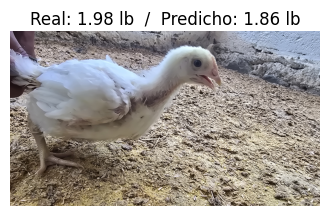

In [18]:
# Tomemos un ejemplo aleatorio de test_df para ver la predicción vs el valor real
import random

idx_ale = random.randint(0, len(test_df) - 1)
fila = test_df.reset_index(drop=True).loc[idx_ale]
img_path = os.path.join(DATA_DIR, fila["filename"])

# 1) Cargar y preprocesar imagen
img = Image.open(img_path).convert("RGB")
img_proc = val_transforms(img).unsqueeze(0).to(device)  # [1,3,224,224]

# 2) Preparar metadatos (edad_norm, sex_bin)
meta_ale = torch.tensor([[fila["age_norm"], fila["sex_bin"]]], dtype=torch.float32).to(device)  # [1,2]
# 2) Imprimir el texto completo de “Ejemplo de validación”
print("Ejemplo de validación:")
print(fila)  # Aquí sale toda la info: filename, weight, age, sex, sex_bin, age_norm, etc.
# 3) Inferir
modelo_mejor.eval()
with torch.no_grad():
    pred = modelo_mejor(img_proc, meta_ale).item()

print(f"Peso real:     {fila['weight']:.4f} lb")
print(f"Peso estimado: {pred:.4f} lb")

# 4) Mostrar la imagen
plt.figure(figsize=(4,4))
plt.imshow(img)
plt.axis("off")
plt.title(f"Real: {fila['weight']:.2f} lb  /  Predicho: {pred:.2f} lb")
plt.show()


In [19]:
import cv2
import torch
import numpy as np
from PIL import Image
import torchvision.transforms as T

# 1.1 Detectamos si hay GPU disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando dispositivo:", device)

# 1.2 Cargar YOLOv5s preentrenado (COCO) para detectar “bird”
#     (Clases COCO: la 14 es “bird” – lo usaremos como proxy de “pollo”)
yolo_detector = torch.hub.load(
    'ultralytics/yolov5',
    'yolov5s',        # modelo YOLOv5s preentrenado en COCO
    pretrained=True
)
yolo_detector.to(device).eval()

# 1.3 Cargar tu regresor scriptado TorchScript (float32)
#     Asegúrate que el archivo exista en tu carpeta de trabajo:
#       - pollo_regressor_scripted_float.pt
modelo_regressor_ts = torch.jit.load("pollo_regressor_scripted_float.pt", map_location=device)
# Si tu TorchScript no estuviese en float32, conviértelo así:
modelo_regressor_ts = modelo_regressor_ts.float().to(device).eval()

# 1.4 Definir el mismo "val_transforms" que usaste para preprocesar imágenes
#     para entrenar/regresor. Debe coincidir exactamente.
val_transforms = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std =[0.229, 0.224, 0.225])
])


Usando dispositivo: cpu


Using cache found in C:\Users\PC}/.cache\torch\hub\ultralytics_yolov5_master
C:\Users\PC}/.cache\torch\hub\ultralytics_yolov5_master\utils\general.py:32: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources as pkg
YOLOv5  2025-6-2 Python-3.12.0 torch-2.7.0+cpu CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


# 12. Inferencia en tiempo real con cámara y detector

In [20]:
# Ajusta la resolución de captura si quieres más velocidad o más detalle:
cap = cv2.VideoCapture(0)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 960)   # ancho
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 540)  # alto

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # 2.1 Detectar “birds” en el frame con YOLOv5s
    #     YOLOv5 acepta un numpy en BGR; internamente lo convertirá a RGB y lo normalizará.
    results = yolo_detector(frame)

    # 2.2 Sacar un DataFrame con cada detección: [xmin, ymin, xmax, ymax, conf, class, name]
    detections = results.pandas().xyxy[0]

    # 2.3 Para cada detección “bird” con confianza >= 0.3 (ajusta el umbral a tu gusto)
    for _, det in detections.iterrows():
        if det["name"] != "bird" or det["confidence"] < 0.3:
            continue

        # 2.3.1 Extraer coordenadas de la caja, recortarla y validar tamaño
        x1, y1 = int(det["xmin"]), int(det["ymin"])
        x2, y2 = int(det["xmax"]), int(det["ymax"])
        h_frame, w_frame, _ = frame.shape
        x1c, y1c = max(0, x1), max(0, y1)
        x2c, y2c = min(w_frame, x2), min(h_frame, y2)
        crop = frame[y1c:y2c, x1c:x2c]
        if crop.size == 0:
            continue

        # 2.3.2 Preprocesar ese recorte exactamente igual que en entrenamiento
        crop_pil = Image.fromarray(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB))
        img_tensor = val_transforms(crop_pil).unsqueeze(0).to(device)  # shape = [1,3,224,224]

        # 2.3.3 Construir metadatos (dummy o reales si los tienes)
        # Ejemplo: edad 24 días → 24/365 ≈0.0658, sexo “hembra” → 0.0
        meta_vals = [24/365.0, 0.0]
        meta_tensor = torch.tensor([meta_vals], dtype=torch.float32).to(device)  # shape = [1,2]

        # 2.3.4 Pasar al regresor scriptado y obtener peso en kg
        with torch.no_grad():
            pred_lb = modelo_regressor_ts(img_tensor, meta_tensor).item()

        # 2.3.5 Convertir kg → libras (si prefieres lb) y armar texto
        
        label = f"Pollo: {pred_lb:.2f} lb"

        # 2.3.6 Dibujar rectángulo verde y poner texto sobre el recorte
        cv2.rectangle(frame, (x1c, y1c), (x2c, y2c), (0, 255, 0), 2)
        cv2.putText(frame, label, (x1c, y1c - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

    # 2.4 Mostrar el frame completo con todas las detecciones y etiquetas de peso
    cv2.imshow("YOLOv5 + Regresor Peso Pollo (Tiempo Real)", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


C:\Users\PC}/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
C:\Users\PC}/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
C:\Users\PC}/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
C:\Users\PC}/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
C:\Users\PC}/.cache\torch\hub\ultralytics_yolov5_master\models\common.py